In [1]:
#!pwd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import sys
import itertools
from collections import Counter, defaultdict
import numpy as np
import scipy.stats, scipy.spatial, scipy.signal
import os
import json
from path import Path; Path.stem = Path.namebase
from natsort import natsorted
from tqdm import tqdm

from ppm3d import Cluster, align, AlignedData
from motifextraction import load_cns
from motifextraction.utils import get_norm_factors, FractionalCounter

In [2]:
data_path = Path("../data")
cluster_path = data_path / "clusters"
motif_path = data_path / "averaged"
motif_errors_path = data_path / "motif_errors"
errors_path = data_path / "errors"

In [3]:
cluster_cns = load_cns(cluster_path).astype(int)
NCLUSTERS = len(cluster_cns)
print(NCLUSTERS)
print(Counter(cluster_cns))

Loading cns...
142
Counter({11: 62, 12: 52, 13: 28})


In [8]:
motif_fns = natsorted(motif_path.glob("*.xyz"))
motif_fns = [f for f in motif_fns if not f.stem.startswith("ignore")]
NMOTIFS = len(motif_fns)
print(NMOTIFS)

5


In [9]:
motifs = [Cluster(filename=fn) for fn in motif_fns]

In [10]:
for motif in motifs:
    print(motif.CN)

12
13
12
11
11


In [7]:
for m1, m2 in itertools.combinations(motifs, 2):
    data = AlignedData.from_mapping(align(m1.filename, m2.filename))
    print(data.error, m1.filename.stem, m2.filename.stem, m1.CN, m2.CN)
    
# If two motifs are identical, rename one of them to start with `ignore_`,
#  then rerun this notebook.

# There were 3 motifs that were the same (averaged_1, averaged_2, and averaged_3; the exact numbers may be different for you).
#  I kept one of them and ignored the other two.
#  This reduced the number of identified motifs from 7 to 5.

0.0018985994663774887 averaged_0 averaged_1 12 13
0.0018985993209640292 averaged_0 averaged_2 12 13
0.0018985994945476309 averaged_0 averaged_3 12 13
0.050340142814096385 averaged_0 averaged_4 12 12
0.03679098893935528 averaged_0 averaged_5 12 11
0.049098749864440856 averaged_0 averaged_6 12 11
9.143950989541127e-09 averaged_1 averaged_2 13 13
1.0416761005950335e-08 averaged_1 averaged_3 13 13
0.038597085097359214 averaged_1 averaged_4 13 12
0.03761310906836501 averaged_1 averaged_5 13 11
0.05219956827263869 averaged_1 averaged_6 13 11
4.438705707003952e-09 averaged_2 averaged_3 13 13
0.03619557873951272 averaged_2 averaged_4 13 12
0.037613109107217234 averaged_2 averaged_5 13 11
0.05296763399885066 averaged_2 averaged_6 13 11
0.03619557708311361 averaged_3 averaged_4 13 12
0.03761310880766914 averaged_3 averaged_5 13 11
0.05219956387591183 averaged_3 averaged_6 13 11
0.0026237498401509673 averaged_4 averaged_5 12 11
0.04805389731133036 averaged_4 averaged_6 12 11
0.04660025505512661 a

In [11]:
# Only clusters with CN >= 10 were considered.
#  This was coded into the `generate_clusters_for_alignment.py` file at the
#  very beginning of this example.
clusters = [Cluster(filename=cluster_path / f"{i}.xyz") for i in range(NCLUSTERS)]

In [12]:
# Load norm factors
with open(data_path / "norm_factors.json") as f:
    _norm_factors = json.load(f)
    L2_norm_factors = _norm_factors["L2"]
    L1_norm_factors = _norm_factors["L1"]
    Linf_norm_factors = _norm_factors["Linf"]
    angular_norm_factors = _norm_factors["angular"]
norm_factors = {"L2": L2_norm_factors, "L1": L1_norm_factors, "Linf": Linf_norm_factors, "angular": angular_norm_factors}

In [13]:
# Load motif errors
motif_errors = np.zeros((NMOTIFS, NCLUSTERS, 4))
motif_errors.fill(np.nan)
for i, fn in enumerate(motif_fns):
    stem = '_'.join(fn.namebase.split('_')[:])
    efn = motif_errors_path / (stem + '_errors.npy')
    motif_errors[i, :, :] = np.load(efn)

motif_errors[:, :, 0]
motif_errors[:, :, 0][np.where(motif_errors[:, :, 0] > L2_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 0][np.isinf(motif_errors[:, :, 0])] = np.nan
motif_errors[:, :, 0] /= L2_norm_factors['divide_by']

motif_errors[:, :, 1]
motif_errors[:, :, 1][np.where(motif_errors[:, :, 1] > L1_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 1][np.isinf(motif_errors[:, :, 1])] = np.nan
motif_errors[:, :, 1] /= L1_norm_factors['divide_by']

motif_errors[:, :, 2]
motif_errors[:, :, 2][np.where(motif_errors[:, :, 2] > Linf_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 2][np.isinf(motif_errors[:, :, 2])] = np.nan
motif_errors[:, :, 2] /= Linf_norm_factors['divide_by']

motif_errors[:, :, 3]
motif_errors[:, :, 3][np.where(motif_errors[:, :, 3] > angular_norm_factors['set_to_inf_before_dividing'])] = np.inf
motif_errors[:, :, 3][np.isinf(motif_errors[:, :, 3])] = np.nan
motif_errors[:, :, 3] /= angular_norm_factors['divide_by']

motif_errors = scipy.stats.gmean(motif_errors, axis=2)
print(motif_errors.shape)

(5, 142)


In [14]:
# Assign
def assign(c, motifs, motif_errors):
    e = np.inf
    idx = np.nan
    for i, motif in enumerate(motifs):
        if np.abs(cluster_cns[c] - motif.CN) > 0:  # Enforce CN similarity +- 0
            continue
        if motif_errors[i, c] < e:
            e = motif_errors[i, c]
            idx = i
    return idx, e

assignments = np.zeros((NCLUSTERS))
assignments.fill(np.nan)
for c in range(NCLUSTERS):
    assignments[c] = assign(c, motifs, motif_errors)[0]

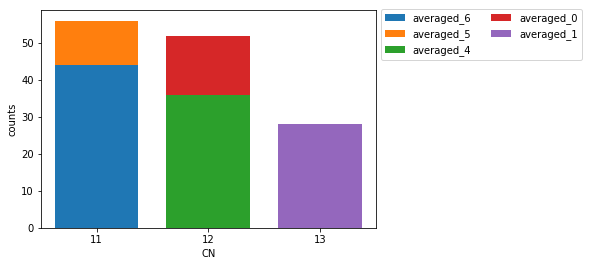

In [15]:
cnmin = min({motif.CN for motif in motifs})
cnmax = max({motif.CN for motif in motifs})
c = Counter(assignments[~np.isnan(assignments)].astype(int))
c_frac = Counter(assignments[~np.isnan(assignments)].astype(int))
c = Counter({motifs[i]: count for i, count in c.items()})
c_frac = Counter({motifs[i]: count for i, count in c_frac.items()})

for motif, count in c.most_common():
    #print(count, motif.filename.stem)
    cn_frac = len([motif for motif in motifs if motif.CN == motif.CN]) / float(NMOTIFS)
    c_frac[motif] = count*cn_frac

# normalize by CN distribution of the model
colors = itertools.cycle([f'C{i}' for i in range(10)])
bar_totals = defaultdict(int)
width = 0.75
for motif, count in sorted(c.most_common(), key=lambda pair: pair[0].CN):
    f = sum(cluster_cns == motif.CN)
    label = motif.filename.stem
    plt.bar([motif.CN], [count],
            width=width,
            bottom=[bar_totals[motif.CN]],
            color=next(colors),
            label=label
            )
    bar_totals[motif.CN] += count
    #print(motif.filename.stem, round(count / float(f) * 100, 1))
plt.xlim([cnmin - .5, cnmax +.5])
plt.legend(bbox_to_anchor=(1, 1.03), ncol=2)
plt.xlabel("CN")
plt.ylabel("counts")
plt.xticks(list(range(cnmin, cnmax+1)))
plt.show()

In [16]:
counter = defaultdict(Counter)
for i in range(NCLUSTERS):
    a = assignments[i]
    if np.isnan(a):
        continue
    m = motifs[int(a)]
    c = clusters[i]
    counter[m][c.atoms[-1].symbol] += 1

In [17]:
for m, c in counter.items():
    print(m.filename.stem, m.CN, c)

averaged_1 13 Counter({'Zr': 28})
averaged_0 12 Counter({'Zr': 16})
averaged_4 12 Counter({'Zr': 36})
averaged_5 11 Counter({'Zr': 12})
averaged_6 11 Counter({'Cu': 44})


In [18]:
# Conclusion:
#  * There are two Zr environments with CN 12.
#  * There is one Zr environment and one Cu environment with CN 11.
#  * There is one Zr environment with CN 13.
#  * There is one Cu environment with CN 11.
#  * These are the 5 environments in the crystal. They are unique (as determined by the
#    motif-to-motif alignments above.)

In [19]:
# Finally, we can check to make sure all clusters are identical to one of the motifs.
for i in range(motif_errors.T.shape[0]):
    if not np.any(np.isclose(motif_errors.T[i], 0, atol=1e-3)):
        print(i, clusters[i].center_atom.symbol, clusters[i].CN, np.nanmin(motif_errors.T[i]))
# No results! That means no clusters were found that are noticeably different than one of the motifs